# Tuto transfert de style rapide pour les styles arbitraires
Tuto à voir ici hihi : https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization

Modèle : https://github.com/magenta/magenta/tree/master/magenta/models/arbitrary_image_stylization

In [1]:
import functools
import os
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
# Define image loading and visualization functions

def crop_center(image):
    """Retourne une image rognée carrée."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
    return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """Chargement et prétraitement des images."""
    
    # Stocke dans le cache le fichier image localement
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    
    # Charge et convertit en numpy array de float32, ajoute la dimension batch, et normalise à l'intervalle [0, 1].
    img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
    if img.max() > 1.0:
        img = img / 255.
    if len(img.shape) == 3:
        img = tf.stack([img, img, img], axis=-1)
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w  * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

Exemple : 

729088/725345 [==============================] - 7s 9us/step


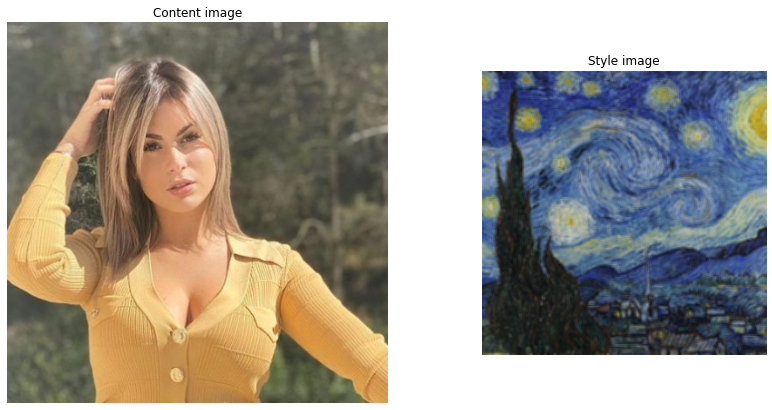

In [4]:
# Chargement des images d'exemple

content_image_url = 'https://resize.programme-television.ladmedia.fr/r/670,670/img/var/premiere/storage/images/tele-7-jours/news-tv/carla-moreau-les-marseillais-apres-l-affaire-de-sorcellerie-elle-repond-a-une-nouvelle-polemique-4670722/99427758-1-fre-FR/Carla-Moreau-Les-Marseillais-Apres-l-affaire-de-sorcellerie-elle-repond-a-une-nouvelle-polemique.jpg'  
style_image_url = 'https://www.kazoart.com/blog/wp-content/uploads/2017/03/van-gogh-la-nuit-etoilee-1.jpg'  
output_image_size = 384  

# La taille de l'image de contenu peut être arbitraire
content_img_size = (output_image_size, output_image_size)

# Le modèle de prédiction de style a été entraîné avec une taille d'image de 256 et c'est la
# taille d'image recommandée pour l'image de style (en effet, d'autre tailles fonctionnent 
# aussi bien mais auront des résultats différents
style_img_size = (256, 256)  # Recommandé de le laisse à 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Importons le module TF-Hub

In [5]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

La signature de ce module hub pour la stylisation d'image est:

In [6]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

Où `content_image`, `style_image` et `stylized_image` sont censés être des tenseurs 4-D avec des formes `[batch_size, image_height, image_width, 3]`.

Dans l'exemple actuel, nous ne fournissons que des images uniques et donc la dimension du lot est 1, mais on peut utiliser le même module pour traiter plusieurs images en même temps.

Les valeurs d'entrée et de sortie des images doivent être comprises entre [0, 1].

Les formes du contenu et de l'image de style ne doivent pas nécessairement correspondre. La forme de l'image de sortie est la même que la forme de l'image du contenu.

## Démontrons la stylisation de l'image

In [7]:
# Stylise l'image de contenu avec l'image de style donnée

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

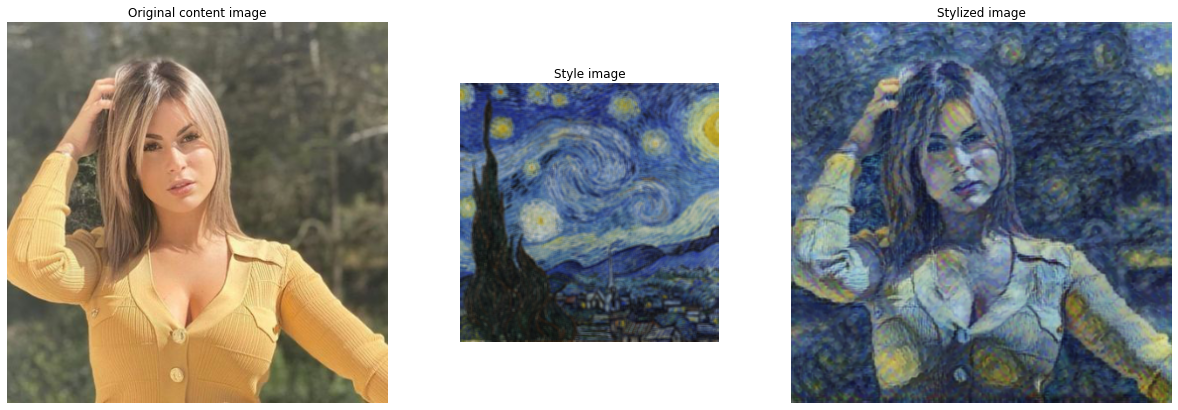

In [8]:
# Visualise les image d'entrée et l'image stylisée générée .

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

## Essayons-le sur plus d'images

In [9]:
# Chargement de plus d'images 

content_urls = dict(
  sea_turtle='https://media.mcetv.fr/wp-content/uploads/2014/03/Cindy-Lopes-SS3-candidate-aux-municipales-%C3%A0-Villeneuve-le-Roi-e1394634072873.jpg',
  tuebingen='http://www.premiere.fr/sites/default/files/styles/partage_rs/public/2018-04/Benoit-Dubois-SS4-nouveau-chroniqueur-des-Anges-de-la-tele-le-mag.jpg',
  grace_hopper='https://static1.purepeople.com/articles/6/41/61/56/@/5985080-thomas-vitiello-de-secret-story-4-lors-amp_article_image_big-3.jpg',
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}

73728/66306 [=================================] - 1s 9us/step


In [ ]:
content_name = 'sea_turtle' 
style_name = 'munch_scream'  

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])